# 월간 데이콘 - 신용카드 사기 거래 탐지
### Objective
: Anomaly Detection(이상치 탐지)
### Settings
: Semi-Supervised learning
> Train data($n=113842$) : Unsupervised(non-labeld) \\
> Validation data($m=28462$) : labeled

- ratio of labeled training data :
$$
\gamma_l = {m\over n+m} ≃ 0.200
$$

In [1]:
import os, sys  
from google.colab import drive  
drive.mount('/content/drive')   

# !pip install pycaret
# !pip install markupsafe==2.0.1 # Requirements on colab

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Data Load
%cd '/content/drive/MyDrive/Github/dacon_FraudDetection'

df_train = pd.read_csv('dataset/train.csv', index_col = 0)
print(df_train.shape)

df_val = pd.read_csv('dataset/val.csv', index_col = 0)
print(df_val.shape)

/content/drive/MyDrive/Github/dacon_FraudDetection
(113842, 30)
(28462, 31)


## Describe statistics
- 주어진 데이터는 표준화된 데이터는 아니며,, principal components 형태로 주어졌을 가능성이 높아보임.
- 변수 V29의 경우 변수 최댓값이 180으로, 다른 변수들에 비해 높게 관찰됨.
- Ratio of pollution in labeled data
$$
\gamma_p ≃ 0.001
$$

In [4]:
# describe - train
df_train.describe() # Not standardized, V29 : max val > 180 : outlier?

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30
count,113842.000000,113842.000000,113842.000000,113842.000000,113842.000000,113842.000000,113842.000000,113842.000000,113842.000000,113842.000000,...,113842.000000,1.138420e+05,113842.000000,113842.000000,113842.000000,113842.000000,113842.000000,113842.000000,113842.000000,113842.000000
mean,0.000197,0.001289,0.009717,-0.004169,0.000475,0.005141,0.005769,-0.002451,-0.002107,0.005209,...,-0.001242,4.088347e-07,-0.001317,-0.000884,0.001680,-0.000293,-0.000234,-0.000508,0.927253,0.116232
std,1.951060,1.651064,1.496916,1.412633,1.367533,1.330583,1.204111,1.185504,1.095415,1.071337,...,0.722001,7.238291e-01,0.636061,0.605854,0.520069,0.480979,0.399505,0.356130,3.412933,0.558161
min,-56.407510,-72.715728,-32.454198,-5.600607,-42.147898,-26.160506,-41.506796,-50.943369,-13.434066,-24.403185,...,-22.757540,-8.887017e+00,-44.807735,-2.824849,-10.295397,-1.855355,-9.895244,-9.617915,-0.307413,-0.994972
25%,-0.923479,-0.595602,-0.883877,-0.853728,-0.689853,-0.766094,-0.552071,-0.209492,-0.647477,-0.533477,...,-0.229710,-5.402665e-01,-0.162180,-0.355582,-0.315470,-0.326160,-0.070847,-0.053249,-0.230560,-0.360304
50%,0.012074,0.066390,0.183868,-0.019359,-0.054060,-0.272436,0.039036,0.020970,-0.052157,-0.090810,...,-0.030281,8.345807e-03,-0.012261,0.040573,0.018278,-0.052815,0.001502,0.011158,-0.000699,-0.002590
75%,1.315373,0.801687,1.037120,0.742208,0.614214,0.405285,0.568750,0.328303,0.590705,0.455287,...,0.186001,5.287508e-01,0.147474,0.438225,0.353989,0.240838,0.091279,0.077851,0.768532,0.640653
max,2.454930,21.467203,4.187811,16.491217,34.801666,23.917837,44.054461,20.007208,10.392889,15.331742,...,27.202839,8.361985e+00,22.528412,4.022866,7.519589,3.119295,11.135740,33.847808,180.101027,1.034951


In [5]:
# describe - val
df_val.describe()
## pollution rate
pd.Series(df_val['Class']).value_counts(normalize = True)

0    0.998946
1    0.001054
Name: Class, dtype: float64

## Correlation
변수 간 상관관계를 heatmap 형태로 표현
- 변수 선택을 점검해야 할 정도로 높은 수준의 상관관계를 보이는 변수는 보이지 않음

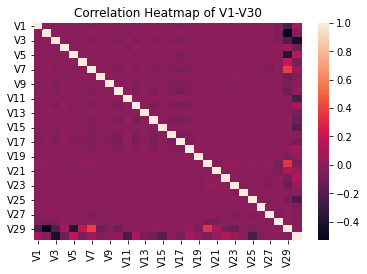

In [6]:
# Correlation plot(heatmap)

corr_matrix = df_train.corr()
sns.heatmap(corr_matrix)
plt.title('Correlation Heatmap of V1-V30')
plt.show()

## Visualize Validation data(labeled)
- Visualize Anomaly and Normal with scatter plot
- By every combination of two variable(e.g. x-axis : V1, y-axis : V2)
- V9*V10 combination에서 Normal/Anomaly의 유의미한 구분이 관측됨

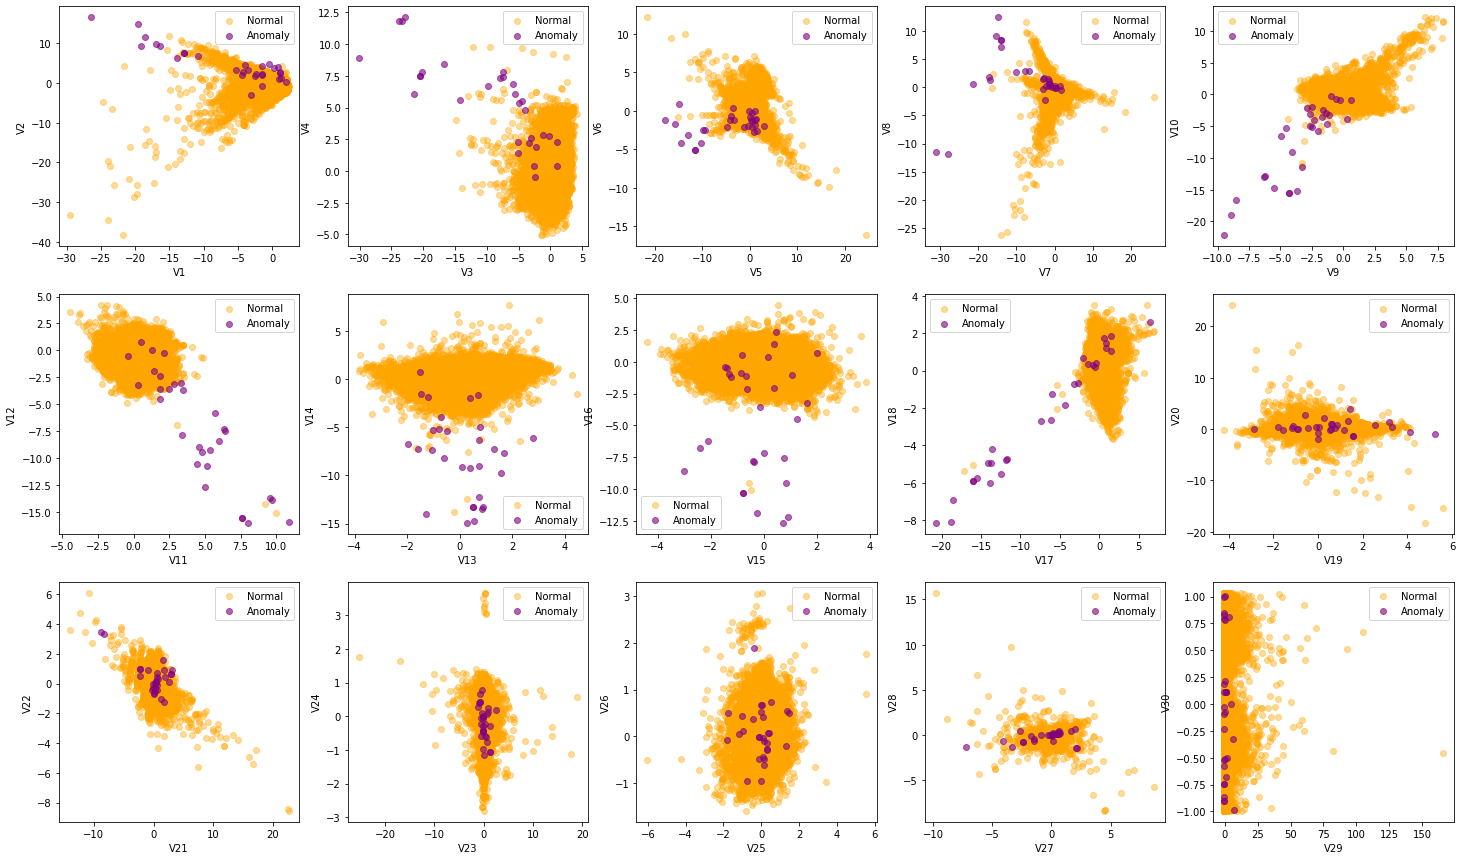

In [16]:
# Visualize(subplots-scatter)
figs, axes = plt.subplots(nrows = 3, ncols = 5, figsize = (25,15))
df_n = df_val.loc[df_val['Class'] == 0 ,:]
df_p = df_val.loc[df_val['Class'] == 1 ,:] # 각각 normal labeled data(class = 0), polluted labeled data

for i in range(15): # combination (V1,V2) to (V29,V30)
  r, c = divmod(i, 5)
  colnames = ['V'+str(i*2+1),'V'+str(i*2+2)]
  xns, yns = pd.array(df_n[colnames[0]]), pd.array(df_n[colnames[1]])
  xps, yps = pd.array(df_p[colnames[0]]), pd.array(df_p[colnames[1]])
  axes[r][c].scatter(xns, yns, c = 'orange', alpha = 0.4, label = 'Normal')
  axes[r][c].scatter(xps, yps, c = 'purple', alpha = 0.6, label = 'Anomaly')
  axes[r][c].legend()
  axes[r][c].set(xlabel = colnames[0], ylabel = colnames[1])

plt.show()